# DeepDream

We are going to implement DeepDream with ResNet50 algorithm. DeepDream shows the patterns that a neural network has discovered. To do this, an image is transmitted across the network, and after that, the gradient of the image with respect to the activations of a given layer is calculated. The image is then altered to boost these activations, strengthening the patterns noticed by the network and creating a visual that resembles a dream. First, we import the required libraries.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10,10)
mpl.rcParams['axes.grid'] = False
import matplotlib.pyplot as plt
import IPython.display as display
import PIL.Image
import time


 Now we download an image for this purpose.

In [2]:
url = 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg'

83281/83281 [==============================] - 0s 0us/step


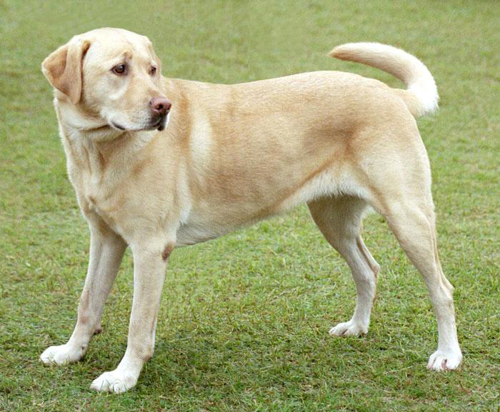

In [3]:
# Download an image and read it into a NumPy array.
def download(url, max_dim=None):
  name = url.split('/')[-1]
  image_path = tf.keras.utils.get_file(name, origin=url)
  img = PIL.Image.open(image_path)
  if max_dim:
    img.thumbnail((max_dim, max_dim))
  return np.array(img)

# Normalize an image
def deprocess(img):
  img = 255*(img + 1.0)/2.0
  return tf.cast(img, tf.uint8)

# Display an image
def show(img):
  display.display(PIL.Image.fromarray(np.array(img)))


# Downsizing the image makes it easier to work with.
original_img = download(url, max_dim=500)
show(original_img)
display.display(display.HTML('Image cc-by: <a "href=https://commons.wikimedia.org/wiki/File:Felis_catus-cat_on_snow.jpg">Von.grzanka</a>'))

First, we download and prepare a pre-trained image classification model. Any pre-trained model can be selected to know the function of each layer of that model. Because the Inception model creates nice-looking dreams in practice, the DeepDream creators chose to utilize it. You will use ResNet50. 

In [4]:
base_model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet')

94765736/94765736 [==============================] - 1s 0us/step


In DeepDream a layer (or layers) is chosen and the "loss" is maximized in a way that the image increasingly "excites" the layers. Depending on the layers selected, the features' complexity can vary. Deeper layers typically produce complicated features in images or even entire things, whereas lower layers typically produce strokes or basic patterns. Typically, higher-level features (such eyes and faces) are generated by deeper layers, while simpler features (such as edges, shapes, and textures) are generated by earlier layers. The deeper the layers, the longer it will take to train on. Here we first look at the layers. Then we select one of the primary layers and then one of the deep layers to compare their output and see the performance of each layer of the selected network.

In [5]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                        

In [6]:
for layer in base_model.layers: 
  print(layer.name)

input_1
conv1_pad
conv1_conv
conv1_bn
conv1_relu
pool1_pad
pool1_pool
conv2_block1_1_conv
conv2_block1_1_bn
conv2_block1_1_relu
conv2_block1_2_conv
conv2_block1_2_bn
conv2_block1_2_relu
conv2_block1_0_conv
conv2_block1_3_conv
conv2_block1_0_bn
conv2_block1_3_bn
conv2_block1_add
conv2_block1_out
conv2_block2_1_conv
conv2_block2_1_bn
conv2_block2_1_relu
conv2_block2_2_conv
conv2_block2_2_bn
conv2_block2_2_relu
conv2_block2_3_conv
conv2_block2_3_bn
conv2_block2_add
conv2_block2_out
conv2_block3_1_conv
conv2_block3_1_bn
conv2_block3_1_relu
conv2_block3_2_conv
conv2_block3_2_bn
conv2_block3_2_relu
conv2_block3_3_conv
conv2_block3_3_bn
conv2_block3_add
conv2_block3_out
conv3_block1_1_conv
conv3_block1_1_bn
conv3_block1_1_relu
conv3_block1_2_conv
conv3_block1_2_bn
conv3_block1_2_relu
conv3_block1_0_conv
conv3_block1_3_conv
conv3_block1_0_bn
conv3_block1_3_bn
conv3_block1_add
conv3_block1_out
conv3_block2_1_conv
conv3_block2_1_bn
conv3_block2_1_relu
conv3_block2_2_conv
conv3_block2_2_bn
conv3_

First, we select the “conv2_block1_1_conv” layer.

In [7]:
# Maximize the activations of these layers
names = ['conv2_block1_1_conv']
layers = [base_model.get_layer(name).output for name in names]

# Create the feature extraction model
dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)

In DeepDream, we will maximize the loss via gradient ascent. The sum of the activations in the chosen layers is the loss. Each layer's contribution to the loss is normalized, preventing bigger layers from outweighing smaller layers. Loss is typically a quantity that we want to reduce through gradient descent. 

In [8]:
def calc_loss(img, model):
  # Pass forward the image through the model to retrieve the activations.
  img_batch = tf.expand_dims(img, axis=0)
  layer_activations = model(img_batch)
  if len(layer_activations) == 1:
    layer_activations = [layer_activations]

  losses = []
  for act in layer_activations:
    loss = tf.math.reduce_mean(act)
    losses.append(loss)

  return  tf.reduce_sum(losses)

All that is left to do is compute the gradients with respect to the image and then add them to the original image after you have determined the loss for the selected layers. The gradients improve the image's pattern recognition capabilities for the network. An image is created that increasingly excites the activations of certain layers in the network at each step. 

In [9]:
class DeepDream(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(
      input_signature=(
        tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
        tf.TensorSpec(shape=[], dtype=tf.int32),
        tf.TensorSpec(shape=[], dtype=tf.float32),)
  )
  def __call__(self, img, steps, step_size):
      print("Tracing")
      loss = tf.constant(0.0)
      for n in tf.range(steps):
        with tf.GradientTape() as tape:
          # This needs gradients relative to `img`
          # `GradientTape` only watches `tf.Variable`s by default
          tape.watch(img)
          loss = calc_loss(img, self.model)

        # Calculate the gradient of the loss with respect to the pixels of the input image.
        gradients = tape.gradient(loss, img)

        # Normalize the gradients.
        gradients /= tf.math.reduce_std(gradients) + 1e-8 
        
        # In gradient ascent, the "loss" is maximized so that the input image increasingly "excites" the layers.
        # You can update the image by directly adding the gradients (because they're the same shape!)
        img = img + gradients*step_size
        img = tf.clip_by_value(img, -1, 1)

      return loss, img

In [10]:
deepdream = DeepDream(dream_model)

Here the main loop is executed to update the photo.

In [11]:
def run_deep_dream_simple(img, steps=100, step_size=0.01):
  # Convert from uint8 to the range expected by the model.
  img = tf.keras.applications.resnet50.preprocess_input(img)
  img = tf.convert_to_tensor(img)
  step_size = tf.convert_to_tensor(step_size)
  steps_remaining = steps
  step = 0
  while steps_remaining:
    if steps_remaining>100:
      run_steps = tf.constant(100)
    else:
      run_steps = tf.constant(steps_remaining)
    steps_remaining -= run_steps
    step += run_steps

    loss, img = deepdream(img, run_steps, tf.constant(step_size))
    
    display.clear_output(wait=True)
    show(deprocess(img))
    print ("Step {}, loss {}".format(step, loss))


  result = deprocess(img)
  display.clear_output(wait=True)
  show(result)

  return result

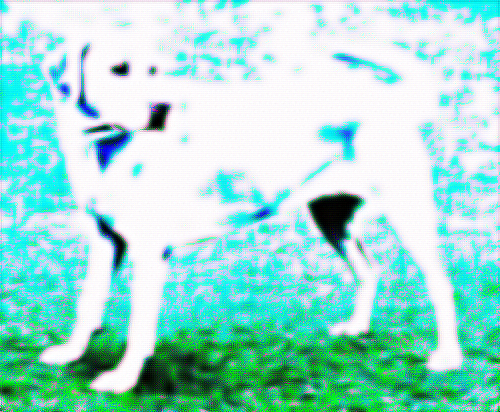

Total time: 16.6897s


In [12]:
start_time = time.time()
dream_img = run_deep_dream_simple(img=original_img, 
                                  steps=100, step_size=0.01)
end_time = time.time()
print('Total time: {:.4f}s'.format(end_time - start_time))

Now we perform the same steps for another layer that has a greater depth called 'conv5_block3_3_conv'.

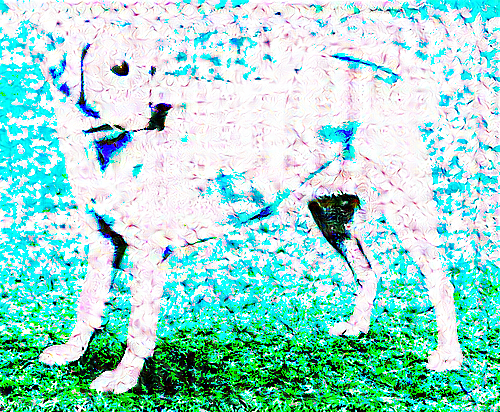

Total time: 170.2484s


In [13]:
names = ['conv5_block3_3_conv']
 
layers = [base_model.get_layer(name).output for name in names]

# Create the feature extraction model
dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)

deepdream = DeepDream(dream_model)
def run_deep_dream_simple(img, steps=100, step_size=0.01):
  # Convert from uint8 to the range expected by the model.
  img = tf.keras.applications.resnet50.preprocess_input(img)
  img = tf.convert_to_tensor(img)
  step_size = tf.convert_to_tensor(step_size)
  steps_remaining = steps
  step = 0
  while steps_remaining:
    if steps_remaining>100:
      run_steps = tf.constant(100)
    else:
      run_steps = tf.constant(steps_remaining)
    steps_remaining -= run_steps
    step += run_steps

    loss, img = deepdream(img, run_steps, tf.constant(step_size))
    
    display.clear_output(wait=True)
    show(deprocess(img))
    print ("Step {}, loss {}".format(step, loss))

  result = deprocess(img)
  display.clear_output(wait=True)
  show(result)

  return result

start_time = time.time()
dream_img = run_deep_dream_simple(img=original_img, 
                                  steps=100, step_size=0.01)
end_time = time.time()
print('Total time: {:.4f}s'.format(end_time - start_time))


We can see that in ResNet50, deeper layers are more related to the details of the image. In addition, due to the depth of this layer, its execution time has been longer.

•	Octave

This is good, but if the pretrained network was trained on relatively small image sizes, like ImageNet, the DeepDream algorithm would print a lot of little patterns in the image that look noisy rather than artistic when the input image is rather large. This occurs as a result of the size of all retrieved features being small. Additionally, the image appears to have little resolution, and all of the patterns seem to be occurring at the same granularity.The DeepDream algorithm processes the input image at several scales known as octaves in order to resolve this issue. Simply put, an interval is referred to as an octave. The goal is to use intervals to apply the DeepDream algorithm to the input image. First, the image is downscaled repeatedly into various scales. The number of scales is customizable.
The following is what we do for each interval:
1. Add details: To avoid losing a lot of image details with each subsequent scale-up, we add the lost information back into the image to produce blended images.
2. Apply the DeepDream algorithm by running the combined image through it.
3. Scale up to the next interval.
To obtain the final result image, we repeat the upscale, detail injection, and DeepDream procedures. The method is repeated until we are satisfied with the produced art after a specified number of repetitions.


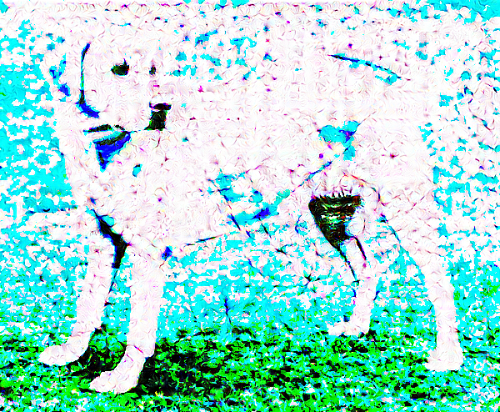

In [14]:
start_time = time.time()

OCTAVE_SCALE = 1.20

img = tf.constant(np.array(original_img))
base_shape = tf.shape(img)[:-1]
float_base_shape = tf.cast(base_shape, tf.float32)

for n in range(-1, 2):
  new_shape = tf.cast(float_base_shape*(OCTAVE_SCALE**n), tf.int32)

  img = tf.image.resize(img, new_shape).numpy()

  img = run_deep_dream_simple(img=img, steps=100, step_size=0.01)

display.clear_output(wait=True)
img = tf.image.resize(img, base_shape)
img = tf.image.convert_image_dtype(img/255.0, dtype=tf.uint8)
show(img)

end_time = time.time()

In [15]:
print('Total time: {:.4f}s'.format(end_time - start_time))

Total time: 525.6693s


•	Scaling up with tiles

One thing to keep in mind is that the gradient calculation will take more time and memory as the image gets bigger. On very large photos or numerous octaves, the octave implementation mentioned above will not work properly. You can divide the image into tiles and determine the gradient for each tile to get around this problem. Before each tiled calculation, the image is given random shifts to avoid appearing tile seams.
The random shift is Implemented at first.


In [16]:
def random_roll(img, maxroll):
  # Randomly shift the image to avoid tiled boundaries.
  shift = tf.random.uniform(shape=[2], minval=-maxroll, maxval=maxroll, dtype=tf.int32)
  img_rolled = tf.roll(img, shift=shift, axis=[0,1])
  return shift, img_rolled

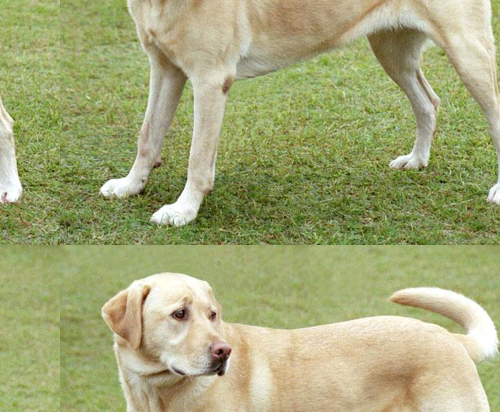

In [17]:
shift, img_rolled = random_roll(np.array(original_img), 512)
show(img_rolled)

Here is a tiled version of the DeepDream function that was previously described:

In [18]:
class TiledGradients(tf.Module):
  def __init__(self, model):
    self.model = model

  @tf.function(
      input_signature=(
        tf.TensorSpec(shape=[None,None,3], dtype=tf.float32),
        tf.TensorSpec(shape=[2], dtype=tf.int32),
        tf.TensorSpec(shape=[], dtype=tf.int32),)
  )
  def __call__(self, img, img_size, tile_size=512):
    shift, img_rolled = random_roll(img, tile_size)

    # Initialize the image gradients to zero.
    gradients = tf.zeros_like(img_rolled)
    
    # Skip the last tile, unless there's only one tile.
    xs = tf.range(0, img_size[1], tile_size)[:-1]
    if not tf.cast(len(xs), bool):
      xs = tf.constant([0])
    ys = tf.range(0, img_size[0], tile_size)[:-1]
    if not tf.cast(len(ys), bool):
      ys = tf.constant([0])

    for x in xs:
      for y in ys:
        # Calculate the gradients for this tile.
        with tf.GradientTape() as tape:
          # This needs gradients relative to `img_rolled`.
          # `GradientTape` only watches `tf.Variable`s by default.
          tape.watch(img_rolled)

          # Extract a tile out of the image.
          img_tile = img_rolled[y:y+tile_size, x:x+tile_size]
          loss = calc_loss(img_tile, self.model)

        # Update the image gradients for this tile.
        gradients = gradients + tape.gradient(loss, img_rolled)

    # Undo the random shift applied to the image and its gradients.
    gradients = tf.roll(gradients, shift=-shift, axis=[0,1])

    # Normalize the gradients.
    gradients /= tf.math.reduce_std(gradients) + 1e-8 

    return gradients 

In [19]:
get_tiled_gradients = TiledGradients(dream_model)

Now we combin these results in a scalable, octave-aware DeepDream implementation.

In [20]:
def run_deep_dream_with_octaves(img, steps_per_octave=10, step_size=0.1, 
                                octaves=range(-1,2), octave_scale=1.3):
  base_shape = tf.shape(img)
  img = tf.keras.utils.img_to_array(img)
  img = tf.keras.applications.resnet50.preprocess_input(img)

  initial_shape = img.shape[:-1]
  img = tf.image.resize(img, initial_shape)
  for octave in octaves:
    # Scale the image based on the octave
    new_size = tf.cast(tf.convert_to_tensor(base_shape[:-1]), tf.float32)*(octave_scale**octave)
    new_size = tf.cast(new_size, tf.int32)
    img = tf.image.resize(img, new_size)

    for step in range(steps_per_octave):
      gradients = get_tiled_gradients(img, new_size)
      img = img + gradients*step_size
      img = tf.clip_by_value(img, -1, 1)

      if step % 10 == 0:
        display.clear_output(wait=True)
        show(deprocess(img))
        print ("Octave {}, Step {}".format(octave, step))
    
  result = deprocess(img)
  return result

Now we run the DeepDream with octaves.

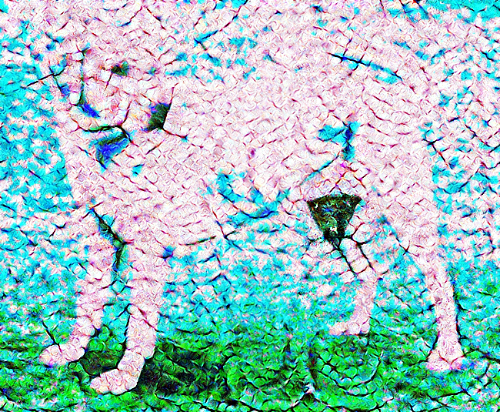

In [21]:
start_time = time.time()
img = run_deep_dream_with_octaves(img=original_img, step_size=0.1)
end_time = time.time()
display.clear_output(wait=True)
img = tf.image.resize(img, base_shape)
img = tf.image.convert_image_dtype(img/255.0, dtype=tf.uint8)
show(img)

In [22]:
print('Total time: {:.4f}s'.format(end_time - start_time))

Total time: 53.9721s
